# Import Libraries

In [1]:
import numpy as np #type: ignore
import random
from collections import defaultdict
from IPython.display import clear_output #type: ignore
import tensorflow as tf #type: ignore
import os
from sklearn.model_selection import train_test_split #type: ignore
import matplotlib.pyplot as plt #type: ignore
from joblib import Parallel, delayed  # for parallelism
import multiprocessing

SEED = 22
np.random.seed(SEED)
random.seed(SEED)

# Connect Four and MCTS Code

In [2]:
def update_board(board_temp,color,column):
    board = board_temp.copy()
    colsum = abs(board[0,column])+abs(board[1,column])+abs(board[2,column])+abs(board[3,column])+abs(board[4,column])+abs(board[5,column])
    row = int(5-colsum)
    if row > -0.5:
        if color == 'plus':
            board[row,column] = 1
        else:
            board[row,column] = -1
    return board
    
def check_for_win_slow(board):
    nrow = board.shape[0]
    ncol = board.shape[1]
    winner = 'nobody'
    for col in range(ncol):
        for row in reversed(range(nrow)):
            if abs(board[row,col]) < 0.1:
                break
            # vertical
            if row <= (nrow-4):
                tempsum = board[row,col]+board[row+1,col]+board[row+2,col]+board[row+3,col]
                if tempsum==4:
                    winner = 'v-plus'
                    return winner
                elif tempsum==-4:
                    winner = 'v-minus'
                    return winner
            # horizontal
            if col <= (ncol-4):
                tempsum = board[row,col]+board[row,col+1]+board[row,col+2]+board[row,col+3]
                if tempsum==4:
                    winner = 'h-plus'
                    return winner
                elif tempsum==-4:
                    winner = 'h-minus'
                    return winner
            # diagonal down-right
            if (row <= (nrow-4)) and (col <= (ncol-4)):
                tempsum = board[row,col]+board[row+1,col+1]+board[row+2,col+2]+board[row+3,col+3]
                if tempsum==4:
                    winner = 'd-plus'
                    return winner
                elif tempsum==-4:
                    winner = 'd-minus'
                    return winner
            # diagonal down-left
            if (row <= (nrow-4)) and (col >= 3):
                tempsum = board[row,col]+board[row+1,col-1]+board[row+2,col-2]+board[row+3,col-3]
                if tempsum==4:
                    winner = 'd-plus'
                    return winner
                elif tempsum==-4:
                    winner = 'd-minus'
                    return winner
    return winner

def check_for_win(board,col):
    nrow = 6
    # figure out what row was just placed
    colsum = abs(board[0,col])+abs(board[1,col])+abs(board[2,col])+abs(board[3,col])+abs(board[4,col])+abs(board[5,col])
    row = int(6-colsum)
    # vertical check
    if row+3<6:
        vert = board[row,col] + board[row+1,col] + board[row+2,col] + board[row+3,col]
        if vert == 4:
            return 'v-plus'
        elif vert == -4:
            return 'v-minus'
    # horizontal checks (there are several)
    # segment 0-3
    if col+3<7:
        hor = board[row,col] + board[row,col+1] + board[row,col+2] + board[row,col+3]
        if hor == 4:
            return 'h-plus'
        elif hor == -4:
            return 'h-minus'
    # segment -1..+2
    if col-1>=0 and col+2<7:
        hor = board[row,col-1] + board[row,col] + board[row,col+1] + board[row,col+2]
        if hor == 4:
            return 'h-plus'
        elif hor == -4:
            return 'h-minus'
    # segment -2..+1
    if col-2>=0 and col+1<7:
        hor = board[row,col-2] + board[row,col-1] + board[row,col] + board[row,col+1]
        if hor == 4:
            return 'h-plus'
        elif hor == -4:
            return 'h-minus'
    # segment -3..0
    if col-3>=0:
        hor = board[row,col-3] + board[row,col-2] + board[row,col-1] + board[row,col]
        if hor == 4:
            return 'h-plus'
        elif hor == -4:
            return 'h-minus'
    # diagonals down-right
    if row < 3 and col < 4:
        DR = board[row,col] + board[row+1,col+1] + board[row+2,col+2] + board[row+3,col+3]
        if DR == 4:
            return 'd-plus'
        elif DR == -4:
            return 'd-minus'
    if row-1>=0 and col-1>=0 and row+2<6 and col+2<7:
        DR = board[row-1,col-1] + board[row,col] + board[row+1,col+1] + board[row+2,col+2]
        if DR == 4:
            return 'd-plus'
        elif DR == -4:
            return 'd-minus'
    if row-2>=0 and col-2>=0 and row+1<6 and col+1<7:
        DR = board[row-2,col-2] + board[row-1,col-1] + board[row,col] + board[row+1,col+1]
        if DR == 4:
            return 'd-plus'
        elif DR == -4:
            return 'd-minus'
    if row-3>=0 and col-3>=0:
        DR = board[row-3,col-3] + board[row-2,col-2] + board[row-1,col-1] + board[row,col]
        if DR == 4:
            return 'd-plus'
        elif DR == -4:
            return 'd-minus'
    # diagonals down-left
    if row+3<6 and col-3>=0:
        DL = board[row,col] + board[row+1,col-1] + board[row+2,col-2] + board[row+3,col-3]
        if DL == 4:
            return 'd-plus'
        elif DL == -4:
            return 'd-minus'
    if row-1>=0 and col+1<7 and row+2<6 and col-2>=0:
        DL = board[row-1,col+1] + board[row,col] + board[row+1,col-1] + board[row+2,col-2]
        if DL == 4:
            return 'd-plus'
        elif DL == -4:
            return 'd-minus'
    if row-2>=0 and col+2<7 and row+1<6 and col-1>=0:
        DL = board[row-2,col+2] + board[row-1,col+1] + board[row,col] + board[row+1,col-1]
        if DL == 4:
            return 'd-plus'
        elif DL == -4:
            return 'd-minus'
    if row-3>=0 and col+3<7:
        DL = board[row-3,col+3] + board[row-2,col+2] + board[row-1,col+1] + board[row,col]
        if DL == 4:
            return 'd-plus'
        elif DL == -4:
            return 'd-minus'
    return 'nobody'

def find_legal(board):
    return [i for i in range(7) if abs(board[0,i]) < 0.1]

def look_for_win(board_,color):
    board_ = board_.copy()
    legal = find_legal(board_)
    winner_col = -1
    for m in legal:
        bt = update_board(board_.copy(),color,m)
        wi = check_for_win(bt,m)
        if wi[2:] == color:
            winner_col = m
            break
    return winner_col

def find_all_nonlosers(board,color):
    if color == 'plus':
        opp = 'minus'
    else:
        opp = 'plus'
    legal = find_legal(board)
    poss_boards = [update_board(board,color,l) for l in legal]
    poss_legal = [find_legal(b) for b in poss_boards]
    allowed = []
    for i in range(len(legal)):
        # if the opponent can immediately win after we move in col=legal[i], skip it
        wins = [j for j in poss_legal[i] 
                if check_for_win(update_board(poss_boards[i],opp,j),j) != 'nobody']
        if len(wins) == 0:
            allowed.append(legal[i])
    return allowed

def back_prop(winner,path,color0,md):
    for i, board_tuple in enumerate(path):
        md[board_tuple][0] += 1
        if winner[2] == color0[0]:
            if i % 2 == 1:
                md[board_tuple][1] += 1
            else:
                md[board_tuple][1] -= 1
        elif winner[2] == 'e':
            # tie => no change
            pass
        else:
            if i % 2 == 1:
                md[board_tuple][1] -= 1
            else:
                md[board_tuple][1] += 1

def rollout(board,next_player):
    winner = 'nobody'
    player = next_player
    while winner == 'nobody':
        legal = find_legal(board)
        if len(legal) == 0:
            return 'tie'
        move = random.choice(legal)
        board = update_board(board,player,move)
        winner = check_for_win(board,move)
        # switch player
        if player == 'plus':
            player = 'minus'
        else:
            player = 'plus'
    return winner
        
def mcts(board_temp,color0,nsteps):
    # Traditional MCTS, plus small improvements:
    board = board_temp.copy()
    # 1. If there's an immediate winning move, use it
    win_col = look_for_win(board,color0)
    if win_col != -1:
        return win_col
    # 2. Look for any moves that avoid an immediate losing position
    legal0 = find_all_nonlosers(board,color0)
    if len(legal0) == 0:
        # if no way to avoid opponent's immediate threat, use all legal moves
        legal0 = find_legal(board)
    
    mcts_dict = {tuple(board.ravel()):[0,0]}
    for _ in range(nsteps):
        color = color0
        winner = 'nobody'
        board_mcts = board.copy()
        path = [tuple(board_mcts.ravel())]
        
        while winner == 'nobody':
            legal = find_legal(board_mcts)
            if len(legal) == 0:
                winner = 'tie'
                back_prop(winner,path,color0,mcts_dict)
                break
            # list of next possible boards
            board_list = []
            for col in legal:
                b_next = update_board(board_mcts,color,col)
                board_list.append(tuple(b_next.ravel()))
                if tuple(b_next.ravel()) not in mcts_dict:
                    mcts_dict[tuple(b_next.ravel())] = [0,0]
            
            # UCB1 
            ucb1 = np.zeros(len(legal))
            for i, bl in enumerate(board_list):
                num_sims, total_value = mcts_dict[bl]
                if num_sims == 0:
                    # large priority for unvisited
                    ucb1[i] = 10 * nsteps
                else:
                    parent_sims = mcts_dict[path[-1]][0]
                    avg_val = total_value / num_sims
                    explore = np.sqrt(np.log(parent_sims)/num_sims)
                    ucb1[i] = avg_val + 2*explore
            
            chosen = np.argmax(ucb1)
            board_mcts = update_board(board_mcts,color,legal[chosen])
            path.append(tuple(board_mcts.ravel()))
            # check winner
            winner = check_for_win(board_mcts,legal[chosen])
            if winner[2] == color[0]:
                back_prop(winner,path,color0,mcts_dict)
                break
            
            # switch player
            color = 'minus' if (color=='plus') else 'plus'
            
            # if the new board has never been visited, do a rollout
            if mcts_dict[tuple(board_mcts.ravel())][0] == 0:
                winner_roll = rollout(board_mcts,color)
                back_prop(winner_roll,path,color0,mcts_dict)
                break
    
    # pick the move with best average reward
    best_col = -1
    max_score = -np.inf
    for col in legal0:
        new_board = tuple(update_board(board,color0,col).ravel())
        num_sims, total_val = mcts_dict[new_board]
        if num_sims == 0:
            # means we never visited it
            score = -np.inf
        else:
            score = total_val/num_sims
        if score > max_score:
            max_score = score
            best_col = col

    return best_col


def board_to_6x7x2(board_2d):
    """
    Convert a 6x7 board with +1, -1, 0 
    into a 6x7x2 one-hot style representation:
       channel 0 => +1 positions
       channel 1 => -1 positions
    """
    X = np.zeros((6,7,2), dtype=np.float32)
    for i in range(6):
        for j in range(7):
            if board_2d[i,j] == 1:
                X[i,j,0] = 1
            elif board_2d[i,j] == -1:
                X[i,j,1] = 1
    return X

def minus_to_plus(board_6x7x2):
    """
    Flip a (6,7,2) board from 'minus perspective' to 'plus perspective'
    by swapping channels 0 and 1.
      channel 0 => +1 squares
      channel 1 => -1 squares
    If originally channel 1 was the 'minus' squares, 
    after swap, that becomes the 'plus' squares, etc.
    """
    flipped = board_6x7x2.copy()
    flipped[..., 0], flipped[..., 1] = board_6x7x2[..., 1], board_6x7x2[..., 0]
    return flipped

def add_symmetric_flips(board_6x7x2, best_move):
    """
    Given a (6,7,2) board and an integer best_move in [0..6],
    return a list of:
      [(original_board_6x7x2, best_move),
       (flipped_board_6x7x2, flipped_move)].
    The flipped version is mirrored left-to-right (column j -> 6-j).
    """
    out = []
    
    # 1) Original
    out.append((board_6x7x2, best_move))
    
    # 2) Flipped left-right
    flipped_board = board_6x7x2[:, ::-1, :].copy()
    flipped_col = 6 - best_move
    out.append((flipped_board, flipped_col))
    
    return out


# Building the Dataset

In [3]:
def play_one_game(
    plus_mcts_steps=800, 
    minus_mcts_steps=800,
    random_openings=2
):
    """
    Play one full game between plus & minus, each side using MCTS.
    - random_openings => number of random moves each side does at the start.
    - We'll capture BOTH plus and minus moves. 
      For minus, we flip the board to plus perspective before storing.
    - We do NOT store random moves. 
    - Return a list of (board_6x7x2, best_move_col) for all MCTS-chosen moves 
      from the plus perspective.
    """
    data_this_game = []
    board = np.zeros((6,7), dtype=np.float32)
    winner = 'nobody'
    player = 'plus'
    move_count = 0
    
    while winner == 'nobody':
        legal = find_legal(board)
        if len(legal) == 0:
            break  # tie

        # Possibly do a random move in the opening
        use_random = False
        if move_count < 2*random_openings:
            # e.g. first X moves in the entire game: random for plus & minus
            use_random = True

        if use_random:
            col = random.choice(legal)
        else:
            # MCTS to pick best move
            if player == 'plus':
                col = mcts(board, 'plus', plus_mcts_steps)
            else:
                col = mcts(board, 'minus', minus_mcts_steps)

        old_board = board.copy()  # board before the current move
        board = update_board(board, player, col)
        winner = check_for_win(board, col)

        # Store the data if this move is MCTS-based (not random)
        if not use_random:
            if player == 'plus':
                # plus perspective => straightforward
                board_6x7x2 = board_to_6x7x2(old_board)
                data_this_game.append((board_6x7x2, col))
            else:
                # minus perspective => flip channels to get plus perspective
                board_6x7x2_minus = board_to_6x7x2(old_board)
                board_6x7x2_plus = minus_to_plus(board_6x7x2_minus)
                # The chosen column from minus's vantage is the same col index on the grid
                data_this_game.append((board_6x7x2_plus, col))

        # Switch player
        player = 'minus' if (player == 'plus') else 'plus'
        move_count += 1
    
    return data_this_game

def play_one_game_random_params():
    """
    Roll random settings:
      plus_mcts_steps   in [500..5000]
      minus_mcts_steps  in [500..5000]
      random_openings   in [1..15]

    Then call play_one_game(...) once.
    Return the list of (board_6x7x2, best_move).
    """
    plus_mcts = random.randint(500, 5000)
    minus_mcts = random.randint(500, 5000)
    openings   = random.randint(1, 15)
    game_data = play_one_game(
        plus_mcts_steps=plus_mcts,
        minus_mcts_steps=minus_mcts,
        random_openings=openings
    )
    return game_data  # list of (board_6x7x2, best_move)

In [4]:
def parallel_build_dataset(num_games=25000):
    """
    Use joblib to run 'play_one_game_random_params()' in parallel.

    We store results in a collision dictionary (board -> {move->count}).
    Then we do final collision resolution + stacking into X,y.

    Returns X, y as np arrays:
      X.shape = (N, 6, 7, 2)
      y.shape = (N,)
    """
    print(f"Building dataset with {num_games} games in parallel...")

    # Step 1: run each game in parallel
    results = Parallel(n_jobs=-1, backend='loky')(
        delayed(play_one_game_random_params)()
        for _ in range(num_games)
    )

    # 'results' is a list of lists. Each sub-list is the (board_6x7x2, best_move) pairs for one game.
    # We'll store them with symmetrical flips & collisions.
    data_dict = defaultdict(lambda: defaultdict(int))

    print("Aggregating results & handling collisions...")

    # Step 2: For each game’s data, do symmetry flips & increment collision dictionary
    for game_data in results:
        for (board_6x7x2, best_move) in game_data:
            # augment
            augmented = add_symmetric_flips(board_6x7x2, best_move)
            for (b_aug, m_aug) in augmented:
                key = b_aug.tobytes()
                data_dict[key][m_aug] += 1

    # Step 3: collision resolution
    X_list = []
    y_list = []
    for key, move_counts in data_dict.items():
        best_move = max(move_counts, key=move_counts.get)
        arr = np.frombuffer(key, dtype=np.float32).reshape(6,7,2)
        X_list.append(arr)
        y_list.append(best_move)

    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=np.int32)
    return X, y

In [47]:
if __name__ == "__main__":
    NUM_GAMES = 25000  
    X, y = parallel_build_dataset(num_games=NUM_GAMES)
    print("Finished building dataset!")
    print("X shape:", X.shape)  # (N,6,7,2)
    print("y shape:", y.shape)
    print("Unique moves in y:", np.unique(y))

    # Save to disk
    np.save("X_dataset_ethan.npy", X) # change filename as needed
    np.save("y_dataset_ethan.npy", y) # change filename as needed
    print("Dataset saved to X_dataset_new.ethan and y_dataset_ethan.npy.")

In [ ]:
# Append dataset code

#def append_datasets(file1_X, file1_y, file2_X, file2_y, out_X, out_y):
#    """
#    Load two Connect4 datasets (X1,y1) and (X2,y2),
#    concatenate them along axis=0,
#    then save as (out_X, out_y).
#    """
#    X1 = np.load(file1_X)
#    y1 = np.load(file1_y)
#    X2 = np.load(file2_X)
#    y2 = np.load(file2_y)

#    print("Before concatenation:")
#    print("  Dataset 1:", X1.shape, y1.shape)
#    print("  Dataset 2:", X2.shape, y2.shape)

#    X_merged = np.concatenate([X1, X2], axis=0)
#    y_merged = np.concatenate([y1, y2], axis=0)

#    print("After concatenation:", X_merged.shape, y_merged.shape)

#    np.save(out_X, X_merged)
#    np.save(out_y, y_merged)
#    print(f"Saved merged dataset to {out_X}, {out_y}.")

#if __name__ == "__main__":
    # Example usage
#    append_datasets(
#        file1_X="X_dataset_new.npy",
#        file1_y="y_dataset_new.npy",
#        file2_X="X_dataset_peer.npy",
#        file2_y="y_dataset_peer.npy",
#        out_X="X_dataset_merged.npy",
#        out_y="y_dataset_merged.npy"
#    )

# Training the CNN

In [3]:
X_file = "X_dataset.npy"
y_file = "y_dataset.npy"

X = np.load(X_file)  # shape (N, 6, 7, 2)
y = np.load(y_file)  # shape (N,)

print("Data shapes:")
print("X:", X.shape)
print("y:", y.shape)
unique_moves = np.unique(y)
print("Unique moves in y:", unique_moves)  # should be [0..6]

Data shapes:
X: (259069, 6, 7, 2)
y: (259069,)
Unique moves in y: [0 1 2 3 4 5 6]


In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=22, 
    shuffle=True
)

print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])

Training set size: 207255
Validation set size: 51814


In [4]:
print("\nAvailable GPUs:", tf.config.list_physical_devices('GPU'))


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Standard CNN

In [ ]:
model = tf.keras.models.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(6, 7, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),  # (6,7)->(3,4)
    
    # Block 2
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),  # (3,4)->(1,2)
    
    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    
    # Block 4 (new)
    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    # Shape = (1,2,256) => total of 512 features after flatten
    
    tf.keras.layers.Flatten(),
    
    # Dense block
    tf.keras.layers.Dense(
        512, 
        kernel_regularizer=tf.keras.regularizers.l2(5e-5)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(
        256, 
        kernel_regularizer=tf.keras.regularizers.l2(5e-5)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.3),
    
    # Output
    tf.keras.layers.Dense(7, activation='softmax')
])

# Start with Adam(1e-4), use ReduceLROnPlateau to dynamically lower it
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Inception-Style CNN

In [81]:
def inception_block(x, filters=64, wd=1e-4):
    """
    A simplified 'Inception-like' block:
      Branch A: 1×1 conv -> 3×3 conv
      Branch B: 1×1 conv -> 5×5 conv
      Branch C: 1×1 conv (just for channel mixing)
    Then we concat them along the channel axis, 
    followed by BatchNorm + ReLU.
    
    'filters' is the number of output filters *per branch*, 
    so total output channels ~ 3 * filters after concat.
    """
    # Branch A
    branch_a = tf.keras.layers.Conv2D(
        filters, kernel_size=1, padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(wd)
    )(x)
    branch_a = tf.keras.layers.ReLU()(branch_a)
    branch_a = tf.keras.layers.Conv2D(
        filters, kernel_size=3, padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(wd)
    )(branch_a)
    
    # Branch B
    branch_b = tf.keras.layers.Conv2D(
        filters, kernel_size=1, padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(wd)
    )(x)
    branch_b = tf.keras.layers.ReLU()(branch_b)
    branch_b = tf.keras.layers.Conv2D(
        filters, kernel_size=5, padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(wd)
    )(branch_b)
    
    # Branch C (just 1×1)
    branch_c = tf.keras.layers.Conv2D(
        filters, kernel_size=1, padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(wd)
    )(x)
    
    # Concatenate along channel axis
    out = tf.keras.layers.Concatenate(axis=-1)([branch_a, branch_b, branch_c])
    # Then BN + ReLU
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.ReLU()(out)
    return out


def build_inception_cnn(input_shape=(6, 7, 2),
                        wd=5e-5,
                        use_global_pool=True):
    """
    A 'pure CNN' using Inception-style blocks, 
    plus optional global average pooling to handle the small 6x7 board.
    """

    inputs = tf.keras.layers.Input(shape=input_shape)

    # (1) Initial Conv
    x = tf.keras.layers.Conv2D(
        32, (3,3), padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(wd)
    )(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # (2) Inception Block #1
    x = inception_block(x, filters=32, wd=wd)

    # (3) Max Pool to reduce from (6,7) => ~ (3,3)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

    # (4) Inception Block #2
    x = inception_block(x, filters=64, wd=wd)

    # (5) Do Global pool
    if use_global_pool:
        # Global Average Pool => shape ~ (batch, channels)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
    else:
        # Flatten directly
        x = tf.keras.layers.Flatten()(x)

    # (6) Dense block
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(
        256,
        kernel_regularizer=tf.keras.regularizers.l2(wd)
    )(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(
        128,
        kernel_regularizer=tf.keras.regularizers.l2(wd)
    )(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # (7) Output layer
    outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs, name="Inception_CNN")
    return model

if __name__ == "__main__":
    model = build_inception_cnn(input_shape=(6,7,2), wd=5e-5)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

Model: "Inception_CNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 7, 2)]    0           []                               
                                                                                                  
 conv2d_33 (Conv2D)             (None, 6, 7, 32)     608         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_45 (BatchN  (None, 6, 7, 32)    128         ['conv2d_33[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_48 (ReLU)                (None, 6, 7, 32)     0           ['batch_normalization

Res-Net Style CNN

In [ ]:
def residual_block(x, filters, kernel_size=(3,3), l2_reg=5e-5):
    """
    A basic ResNet-style block:
      - 2D Convolution -> BN -> ReLU
      - 2D Convolution -> BN
      - Skip connection: add the input 'x' to the result
      - Final ReLU activation
    """
    # Save the input to add back later
    shortcut = x

    # First conv
    x = tf.keras.layers.Conv2D(
        filters, kernel_size, padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Second conv
    x = tf.keras.layers.Conv2D(
        filters, kernel_size, padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Add the shortcut (must have same shape)
    x = tf.keras.layers.Add()([shortcut, x])
    x = tf.keras.layers.ReLU()(x)

    return x

def build_resnet_cnn(input_shape=(6,7,2), num_classes=7, l2_reg=5e-5, dropout_rate=0.3):
    """
    A deeper ResNet-style CNN for Connect4.
    - input_shape: (6,7,2)
    - num_classes: 7 (one per column)
    - l2_reg: L2 regularization factor
    - dropout_rate: dropout ratio in dense layers
    """
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Initial conv: (like a "stem" layer)
    x = tf.keras.layers.Conv2D(
        64, (3,3), padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
    )(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # --- Residual Block 1 (64 filters) ---
    x = residual_block(x, filters=64, l2_reg=l2_reg)

    # Do a second residual block at same (64) filters
    x = residual_block(x, filters=64, l2_reg=l2_reg)

    # MaxPool to reduce from (6,7) -> (3,3)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

    # --- Residual Block 2 (128 filters) ---
    x = tf.keras.layers.Conv2D(128, (1,1), strides=1,  # 1x1 to expand channels
                               padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = residual_block(x, filters=128, l2_reg=l2_reg)

    # (3,3) -> (1,1) with maxpool
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

    # --- Residual Block 3 (256 filters) ---
    # 1x1 conv to expand from 128->256 channels
    x = tf.keras.layers.Conv2D(256, (1,1), strides=1,
                               padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = residual_block(x, filters=256, l2_reg=l2_reg)

    # Flatten
    x = tf.keras.layers.Flatten()(x)  # shape ~ (256,)

    # Dense block
    x = tf.keras.layers.Dense(
        512,
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Dense(
        256,
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Output
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

if __name__ == "__main__":
    model = build_resnet_cnn(input_shape=(6,7,2), num_classes=7, l2_reg=5e-5, dropout_rate=0.3)

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 7, 2)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 6, 7, 64)     1216        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 6, 7, 64)    256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 6, 7, 64)     0           ['batch_normalization[0][0]']

In [6]:
epochs = 50
batch_size = 64

# Early stopping if val_accuracy doesn’t improve for 5 epochs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    restore_best_weights=True
)

# Reduce learning rate by factor of 0.5 if val_accuracy doesn’t improve for 3 epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
3239/3239 [==============================] - 32s 8ms/step - loss: 1.9728 - accuracy: 0.2569 - val_loss: 1.6209 - val_accuracy: 0.3898 - lr: 1.0000e-04
Epoch 2/50
3239/3239 [==============================] - 26s 8ms/step - loss: 1.5570 - accuracy: 0.4207 - val_loss: 1.4170 - val_accuracy: 0.4693 - lr: 1.0000e-04
Epoch 3/50
3239/3239 [==============================] - 26s 8ms/step - loss: 1.4040 - accuracy: 0.4806 - val_loss: 1.3502 - val_accuracy: 0.5005 - lr: 1.0000e-04
Epoch 4/50
3239/3239 [==============================] - 26s 8ms/step - loss: 1.3164 - accuracy: 0.5164 - val_loss: 1.2958 - val_accuracy: 0.5232 - lr: 1.0000e-04
Epoch 5/50
3239/3239 [==============================] - 26s 8ms/step - loss: 1.2451 - accuracy: 0.5448 - val_loss: 1.2579 - val_accuracy: 0.5361 - lr: 1.0000e-04
Epoch 6/50
3239/3239 [==============================] - 27s 8ms/step - loss: 1.1853 - accuracy: 0.5689 - val_loss: 1.2251 - val_accuracy: 0.5508 - lr: 1.0000e-04
Epoch 7/50
3239/3239 [======

In [7]:
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {val_acc*100:.2f}%   (loss={val_loss:.4f})")

Validation accuracy: 57.00%   (loss=1.2238)


In [15]:
model.save("cnn_connect4.h5")
print("Model saved to cnn_connect4.h5.")

Model saved to cnn_connect4.h5.


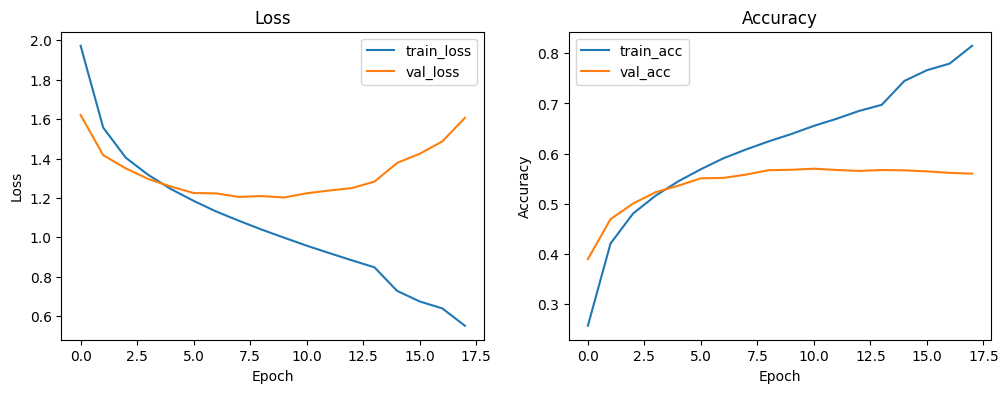

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss
axs[0].plot(history.history['loss'], label='train_loss')
axs[0].plot(history.history['val_loss'], label='val_loss')
axs[0].set_title("Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot accuracy
axs[1].plot(history.history['accuracy'], label='train_acc')
axs[1].plot(history.history['val_accuracy'], label='val_acc')
axs[1].set_title("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.show()

# CNN Testing vs MCTS

In [9]:
def cnn_pick_move(board_2d, model, color='plus'):
    """
    Given a 6x7 board (board_2d) and a trained Keras model,
    pick the column with highest predicted probability (from the CNN)
    that is also legal.
    
    If 'color' == 'minus', we flip channels so the CNN sees "plus perspective."
    That means channel 0 => squares of +1, channel 1 => squares of -1.
    
    Return: int column in [0..6].
    """
    # Convert board to 6x7x2 representation
    from_board = board_to_6x7x2(board_2d)
    
    if color == 'minus':
        # Flip minus -> plus perspective
        from_board = minus_to_plus(from_board)

    # Model expects shape (N, 6, 7, 2). So expand dims.
    input_for_model = np.expand_dims(from_board, axis=0)  # (1,6,7,2)
    
    # Predict probabilities for each column
    # shape: (1,7)
    pred_probs = model.predict(input_for_model, verbose=0)[0]  # (7,)

    # Sort columns by descending probability
    columns_ranked = np.argsort(pred_probs)[::-1]  # highest -> lowest

    # Find a legal column among the top predictions
    legal_cols = find_legal(board_2d)
    for col in columns_ranked:
        if col in legal_cols:
            return col

    # Fallback: if something weird happened (all top columns were illegal),
    # pick a random legal column
    if len(legal_cols) > 0:
        return random.choice(legal_cols)
    else:
        return 0  # if no columns are legal, game is effectively a tie/loss

In [10]:
def play_one_game_CNN_vs_MCTS(model, mcts_steps_minus=300, verbose=False):
    """
    Let the CNN play as 'plus' and MCTS play as 'minus' with mcts_steps_minus.
    Returns: winner (str), number_of_moves
             where winner is in { 'nobody', 'v-plus', 'v-minus', 'h-plus', ... etc. }
    """
    board = np.zeros((6,7), dtype=np.float32)
    winner = 'nobody'
    player = 'plus'
    move_count = 0

    while winner == 'nobody':
        legal = find_legal(board)
        if len(legal) == 0:
            # tie
            break

        if player == 'plus':
            col = cnn_pick_move(board, model, color='plus')
        else:
            col = mcts(board, 'minus', mcts_steps_minus)

        board = update_board(board, player, col)
        winner = check_for_win(board, col)
        
        move_count += 1
        
        if player == 'plus':
            player = 'minus'
        else:
            player = 'plus'

        if verbose:
            print(f"Move {move_count}, {player}, col={col}")

    return winner, move_count

In [11]:
def test_CNN_vs_MCTS(model, num_games=100, mcts_steps_minus=300, verbose=False):
    """
    Play 'num_games' between:
      - CNN as 'plus'
      - MCTS as 'minus' with mcts_steps_minus
    Track how many times plus wins, minus wins, or tie.
    Also track average length of game (moves).
    
    Returns: 
      plus_wins, minus_wins, ties, avg_moves
    """
    plus_wins = 0
    minus_wins = 0
    ties = 0
    total_moves = 0

    for g in range(num_games):
        winner, moves = play_one_game_CNN_vs_MCTS(
            model,
            mcts_steps_minus=mcts_steps_minus,
            verbose=verbose
        )
        total_moves += moves

        if winner == 'nobody' or winner == 'tie':
            ties += 1
        elif winner.endswith('plus'):
            plus_wins += 1
        elif winner.endswith('minus'):
            minus_wins += 1
        else:
            if winner[-4:] == 'plus':
                plus_wins += 1
            else:
                minus_wins += 1
    
    avg_moves = total_moves / num_games if num_games > 0 else 0
    
    return plus_wins, minus_wins, ties, avg_moves

In [14]:
if __name__ == "__main__":
    # model = tf.keras.models.load_model("cnn_connect4.h5")
    
    num_games = 50
    mcts_steps = 1000  # how many MCTS steps minus uses

    pw, mw, ts, am = test_CNN_vs_MCTS(model, num_games=num_games, mcts_steps_minus=mcts_steps, verbose=False)
    
    print(f"Out of {num_games} games vs. MCTS({mcts_steps} steps):")
    print(f"  CNN (plus) wins:  {pw}")
    print(f"  MCTS (minus) wins: {mw}")
    print(f"  Ties: {ts}")
    print(f"  Average number of moves per game: {am:.1f}")

Out of 50 games vs. MCTS(300 steps):
  CNN (plus) wins:  29
  MCTS (minus) wins: 18
  Ties: 3
  Average number of moves per game: 30.1
